In [1]:
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_2 import MaskedConditionalGapFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal_IMR
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# def estimate_physical_parameters(signal):
#     """
#     估计信号的物理参数，例如频率、相位和振幅。
#     这是一个简单的示例实现，具体实现应根据你的需求进行调整。
#     """
#     # 假设信号是一个简单的正弦波，我们可以估计它的幅度、频率和相位
#     amplitude = signal.abs().max().item()  # 估计振幅
#     frequency = torch.fft.fftfreq(signal.size(0)).abs().argmax().item()  # 估计频率
#     phase = torch.atan2(signal[1], signal[0]).item()  # 估计相位

#     return [amplitude, frequency, phase]
 
 
import numpy as np
from math import pi 
c =2.9979246*1e8
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD






/home/ljq/miniconda3/envs/gw_ml_env/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
/home/ljq/miniconda3/envs/gw_ml_env/lib/python3.10/site-packages/torch/cuda/__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5080 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_70 sm_75 sm_80 sm_86 sm_90

In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt, get_window
from scipy.fft import rfft, irfft
from scipy.interpolate import interp1d

def whiten(data, sample_rate, fftlength=2, overlap=0, method='median', 
                window='hann', detrend='constant', psd=None, 
                fduration=2, highpass=None):
    """
    完整复现 TimeSeries 白化功能的函数

    参数:
    ----------
    data : `numpy.ndarray`
        输入的时间序列数据
    sample_rate : `float`
        采样率
    fftlength : `float`
        FFT 积分时长（以秒为单位）
    overlap : `float`
        FFT 窗口重叠部分的时长（以秒为单位）
    method : `str`
        ASD 估计方法 ('median', 'bartlett', 'welch')
    window : `str`
        窗口类型，默认为 'hann'，可以是 `scipy.signal.get_window` 支持的任何窗口
    detrend : `str`
        去趋势方法 ('constant', 'linear')
    asd : `numpy.ndarray`, optional
        ASD ：如果已经有 ASD ，可以直接传入不再计算
    fduration : `float`
        FIR 滤波器的时长（以秒为单位）
    highpass : `float`, optional
        高通滤波器的截止频率，默认为 None

    返回:
    ----------
    whitened_data : `numpy.ndarray`
        白化后的数据
    """
    
    # Step 1: 计算 ASD（使用 FFT）
    N = len(data)
    freqs = np.fft.rfftfreq(N, d=1.0/sample_rate)
    
    if psd is None:
        # 没有给定 ASD，则通过 FFT 计算
        psd = np.abs(np.fft.rfft(data))**2 / N
        asd = np.sqrt(psd)  # ASD 是 PSD 的平方根
        
        # 确保 freqs 和 asd 的长度一致
        if len(freqs) != len(asd):
            min_len = min(len(freqs), len(asd))
            freqs = freqs[:min_len]
            asd = asd[:min_len]

        # 插值 ASD
        interp_asd = interp1d(freqs, asd, kind='linear', fill_value="extrapolate")
        ASD = interp_asd(freqs)
    else:
        PSD=psd(freqs)
        ASD=np.sqrt(PSD)
    # Step 2: 设计 FIR 滤波器（基于 ASD）
    ntaps = int(fduration * sample_rate)
    
    # Step 3: 高通滤波器（可选）
    if highpass:
        nyquist = 0.5 * sample_rate
        norm_highpass = highpass / nyquist
        b_high, a_high = butter(4, norm_highpass, btype='high')
        data = filtfilt(b_high, a_high, data)
    
    # Step 4: 白化滤波器设计（逆 ASD 作为滤波器）
    whiten_filter = 1.0 / ASD
    whiten_filter[:len(whiten_filter)//2] = np.maximum(whiten_filter[:len(whiten_filter)//2], 1e-10)  # 避免除零

    # 生成窗口
    window_vals = get_window(window, N, fftbins=False)
    
    # Step 5: 应用白化滤波器
    # 进行 FFT，将数据转换到频域
    fft_data = rfft(data * window_vals)
    whitened_freq = fft_data * whiten_filter
    whitened_time = irfft(whitened_freq)
    
    # Step 6: 去趋势，恢复时间域信号
    if detrend == 'constant':
        whitened_time -= np.mean(whitened_time)
    elif detrend == 'linear':
        whitened_time -= np.polyval(np.polyfit(np.arange(N), whitened_time, 1), np.arange(N))

    return whitened_time,freqs,ASD

torch.Size([10000, 16512]) (10000, 3, 1)


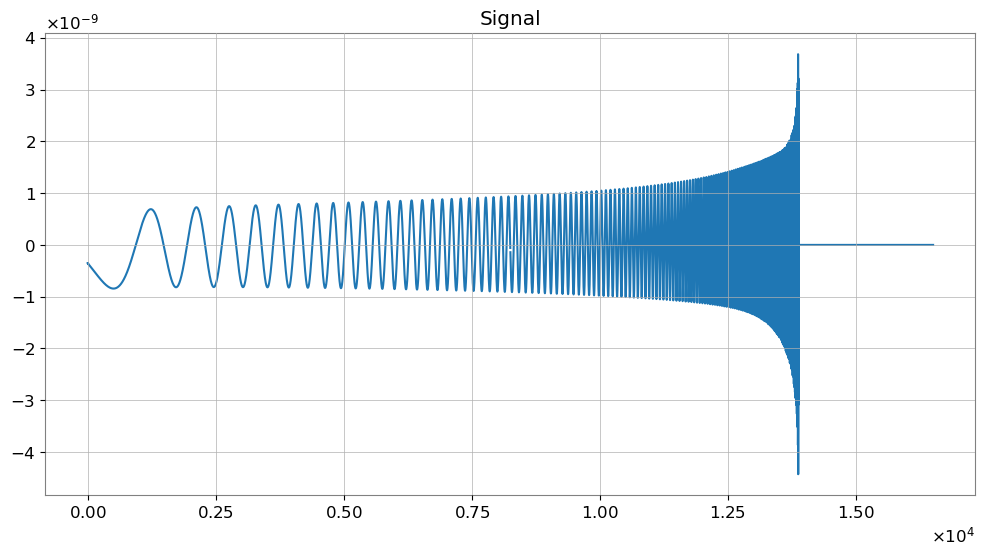

In [3]:
signal_length=Config.signal_length_IMR
gap_size = signal_length//Config.signal_to_gap_length_ratio
%matplotlib inline
import matplotlib.pyplot as plt
data = np.load('data/signal_data_IMR.npz')
#data = np.load('data/test_signal_data.npz')
signals = data['signals'][:,50:50+signal_length]
signals = torch.tensor(signals, dtype=torch.float32)
# noises = data['noises']
# datas= data['datas']
conditions = data['conditions']
print(signals.shape,conditions.shape)

plt.figure(figsize=(12, 6))

plt.plot(signals[0].numpy()*1e6)
plt.title('Signal')
plt.show()


/tmp/ipykernel_38243/622622754.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signals = torch.tensor(signals, dtype=torch.float32)
/home/ljq/code/RingdownGapFilling/utils/normalize.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal=torch.tensor(signal)


[ True  True  True ...  True  True  True]


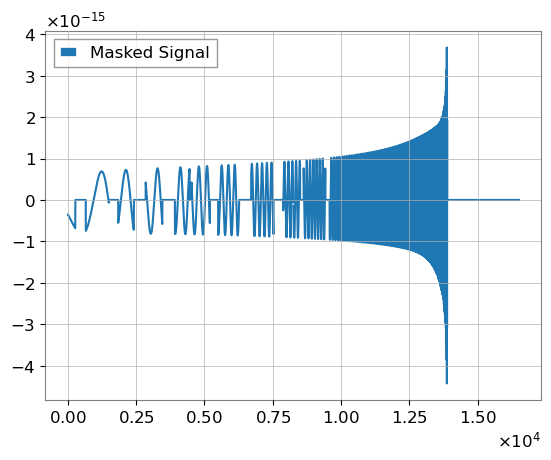

[ True  True  True ...  True  True  True]


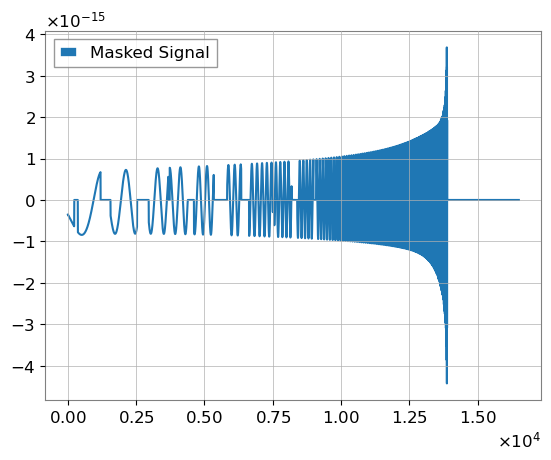

[ True  True  True ...  True  True  True]


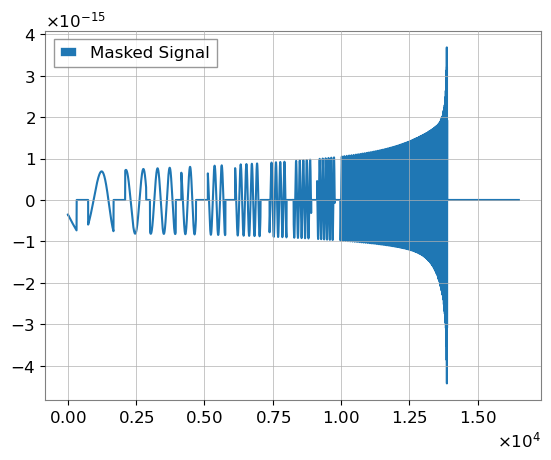

[ True  True  True ...  True  True  True]


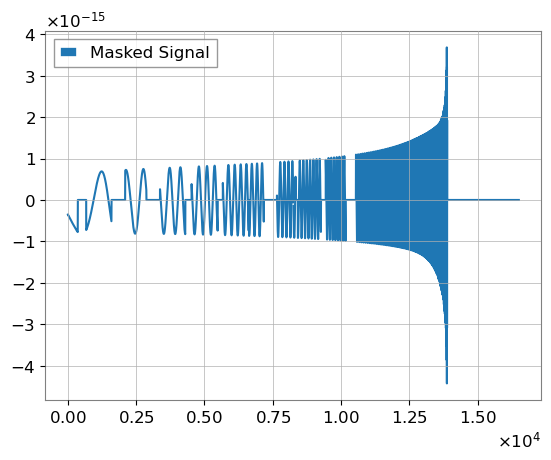

[ True  True  True ...  True  True  True]


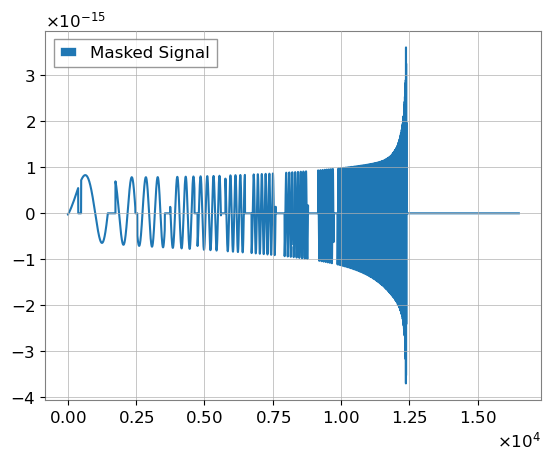

/home/ljq/code/RingdownGapFilling/utils/normalize.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  signal=torch.tensor(signal)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [4]:


#signal,condition=generate_data(1)
# signals=[]
# signal=signal.transpose(0,1)
# print(signal.shape)
# for _ in range(Config.num_samples):
    
#     signals.append(signal)

# #masked_signals = data['masked_signals']

# conditions=[]
# print(condition.shape)
# condition=condition.transpose(1,0)
# for _ in range(Config.num_samples):
    
#     conditions.append(condition)
from utils.noise import *
from utils.mask import *
#数据预处理
#n_signals,mean,std=normalize(signals)
signals = torch.tensor(signals, dtype=torch.float32)
signal_length=len(signals[0])
num_gaps=10

gap_size = int(signal_length//Config.signal_to_gap_length_ratio_IMR)
masks = generate_continuous_masks_IMR(signals.size(0), signal_length, gap_size,num_gaps)
#masks2=generate_continuous_mask(signals.size(0), signal_length, gap_size,start=int(1/2*Config.signal_length)+gap_size)
masked_signals = []
signals_copy=signals 
signals,_,_=normalize(signals)
for i in range(signals_copy.size(0)):
    masked_signal = np.copy(signals_copy[i])
    masked_signal[~masks[i].numpy()] = 0  # 将掩码位置的信号置为0
    #绘制前几个masked信号
    if i< 5:
        print(masks[i].numpy())
        plt.plot(masked_signal, label='Masked Signal')
        plt.legend()
        plt.show()

    
    masked_signals.append(masked_signal)

# masked_datas=masked_signals
# #masked_datas_copy,_,_=normalize(masked_datas)
# whitened_masked_datas=[]
# for i in range(signals_copy.size(0)):
#     masked_data=np.copy(masked_datas[i])
    
#     whitened_masked_data,_,_=whiten(masked_data, sample_rate=2,psd=psd_interp_func,highpass=2e-3)
#     whitened_masked_datas.append(whitened_masked_data)
masked_signals,_,_=normalize(masked_signals)
processed_signals = []
processed_masked_datas = []

i=0
for signal, masked_signal in zip(signals, masked_signals):
    # 对原始信号进行小波变换和分段
    transformed_signal = wavelet_bandpass(signal)
    segmented_signal = segment_signal_IMR(transformed_signal)

    # 对掩码信号进行小波变换和分段
    transformed_masked_signal = wavelet_bandpass(masked_signal)
    segmented_masked_signal = segment_signal_IMR(transformed_masked_signal)

    processed_signals.append(segmented_signal)
    processed_masked_datas.append(segmented_masked_signal)
    print(i)
    i+=1
    
print(1)
dataset = GWSignalDataset(signals,masked_signals,processed_masked_datas, conditions)








In [5]:
import torch



# 保存 dataset
torch.save(dataset, '/home/ljq/code/RingdownGapFilling/dataset/train_dataset_IMR.pth')


In [1]:
import os

os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-12.9/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

import torch

In [1]:

from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_2 import MaskedConditionalGapFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal_IMR
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np
from scipy.signal import butter, filtfilt, get_window
from scipy.fft import rfft, irfft
from scipy.interpolate import interp1d

def whiten(data, sample_rate, fftlength=2, overlap=0, method='median', 
                window='hann', detrend='constant', psd=None, 
                fduration=2, highpass=None):
    """
    完整复现 TimeSeries 白化功能的函数

    参数:
    ----------
    data : `numpy.ndarray`
        输入的时间序列数据
    sample_rate : `float`
        采样率
    fftlength : `float`
        FFT 积分时长（以秒为单位）
    overlap : `float`
        FFT 窗口重叠部分的时长（以秒为单位）
    method : `str`
        ASD 估计方法 ('median', 'bartlett', 'welch')
    window : `str`
        窗口类型，默认为 'hann'，可以是 `scipy.signal.get_window` 支持的任何窗口
    detrend : `str`
        去趋势方法 ('constant', 'linear')
    asd : `numpy.ndarray`, optional
        ASD ：如果已经有 ASD ，可以直接传入不再计算
    fduration : `float`
        FIR 滤波器的时长（以秒为单位）
    highpass : `float`, optional
        高通滤波器的截止频率，默认为 None

    返回:
    ----------
    whitened_data : `numpy.ndarray`
        白化后的数据
    """
    
    # Step 1: 计算 ASD（使用 FFT）
    N = len(data)
    freqs = np.fft.rfftfreq(N, d=1.0/sample_rate)
    
    if psd is None:
        # 没有给定 ASD，则通过 FFT 计算
        psd = np.abs(np.fft.rfft(data))**2 / N
        asd = np.sqrt(psd)  # ASD 是 PSD 的平方根
        
        # 确保 freqs 和 asd 的长度一致
        if len(freqs) != len(asd):
            min_len = min(len(freqs), len(asd))
            freqs = freqs[:min_len]
            asd = asd[:min_len]

        # 插值 ASD
        interp_asd = interp1d(freqs, asd, kind='linear', fill_value="extrapolate")
        ASD = interp_asd(freqs)
    else:
        PSD=psd(freqs)
        ASD=np.sqrt(PSD)
    # Step 2: 设计 FIR 滤波器（基于 ASD）
    ntaps = int(fduration * sample_rate)
    
    # Step 3: 高通滤波器（可选）
    if highpass:
        nyquist = 0.5 * sample_rate
        norm_highpass = highpass / nyquist
        b_high, a_high = butter(4, norm_highpass, btype='high')
        data = filtfilt(b_high, a_high, data)
    
    # Step 4: 白化滤波器设计（逆 ASD 作为滤波器）
    whiten_filter = 1.0 / ASD
    whiten_filter[:len(whiten_filter)//2] = np.maximum(whiten_filter[:len(whiten_filter)//2], 1e-10)  # 避免除零

    # 生成窗口
    window_vals = get_window(window, N, fftbins=False)
    
    # Step 5: 应用白化滤波器
    # 进行 FFT，将数据转换到频域
    fft_data = rfft(data * window_vals)
    whitened_freq = fft_data * whiten_filter
    whitened_time = irfft(whitened_freq)
    
    # Step 6: 去趋势，恢复时间域信号
    if detrend == 'constant':
        whitened_time -= np.mean(whitened_time)
    elif detrend == 'linear':
        whitened_time -= np.polyval(np.polyfit(np.arange(N), whitened_time, 1), np.arange(N))

    return whitened_time,freqs,ASD

/home/ljq/miniconda3/envs/gw_ml_env/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [5]:
# 加载保存的 Dataset
from tqdm import tqdm
from torch.serialization import add_safe_globals
import os
add_safe_globals([GWSignalDataset])
dataset = torch.load('/home/ljq/code/RingdownGapFilling/dataset/train_dataset_IMR.pth')
for i, data in enumerate(tqdm(dataset, desc="Loading dataset")):
    # 如果你需要处理或缓存数据，可以在这里做
    pass
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_4 import IMRGapsFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal_IMR
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#dataset=new_dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = Config.batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)#, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, num_workers=4, pin_memory=True)

# 获取一个批次的数据
targets,_,inputs, conditions = next(iter(train_loader))

#打印形状
# print(f'Inputs shape: {inputs.shape}')  
# print(f'Targets shape: {targets.shape}')  
# print(f'Conditions shape: {conditions.shape}')  

import matplotlib.pyplot as plt

# 可视化第一个批次中的前几个样本
# num_samples_to_plot = 3  # 要绘制的样本数量
# for i in range(num_samples_to_plot):
#     plt.figure(figsize=(10, 4))
#     plt.plot(inputs[i].cpu().numpy(), label='Input (Masked)')
#     plt.plot(targets[i].cpu().numpy(), label='Target (Original)')
#     plt.title(f'Sample {i+1}')
#     plt.xlabel('Time Step')
#     plt.ylabel('Signal Value')
#     plt.legend()
#     plt.show()

Loading dataset: 100%|██████████| 10000/10000 [00:00<00:00, 306944.46it/s]


In [4]:
print(targets.shape, inputs.shape)

torch.Size([8, 16512]) torch.Size([8, 8, 128, 256])


In [5]:
import torch
import os

print("🔹 PyTorch 版本:", torch.__version__)
print("🔹 编译时 CUDA 版本:", torch.version.cuda)
print("🔹 编译是否支持 CUDA:", torch.backends.cuda.is_built())
print("🔹 当前是否可用 CUDA:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("🔹 当前 GPU 名称:", torch.cuda.get_device_name(0))
    print("🔹 当前 GPU Compute Capability:", torch.cuda.get_device_capability(0))
    print("🔹 当前 GPU 总显存: {:.2f} GB".format(torch.cuda.get_device_properties(0).total_memory / (1024**3)))
    print("🔹 当前正在使用的 CUDA 驱动版本:", torch.version.cuda)
else:
    print("⚠️ CUDA 不可用，确认是否驱动/环境配置问题。")

# 打印已编译支持的架构（从环境变量或构建日志得知）
arch_env = os.environ.get("TORCH_CUDA_ARCH_LIST") or os.environ.get("CMAKE_CUDA_ARCHITECTURES")
if arch_env:
    print("🔹 构建目标架构 (来自环境变量):", arch_env)
else:
    print("🔹 无法自动获取目标架构（需查看编译日志中的 `-gencode` 或 CMakeCache）")


🔹 PyTorch 版本: 2.8.0a0+git8faa225
🔹 编译时 CUDA 版本: 12.9
🔹 编译是否支持 CUDA: True
🔹 当前是否可用 CUDA: True
🔹 当前 GPU 名称: NVIDIA GeForce RTX 5080
🔹 当前 GPU Compute Capability: (12, 0)
🔹 当前 GPU 总显存: 15.92 GB
🔹 当前正在使用的 CUDA 驱动版本: 12.9
🔹 构建目标架构 (来自环境变量): 120


In [6]:

SAVE_PATH = '/home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR'
# 定义模型  
model = IMRGapsFiller().to(device)
train_the_model(
    model,
    train_loader,
    val_loader,
    num_epochs=Config.num_epochs,
    learning_rate=Config.learning_rate,
    save_path= SAVE_PATH,
    device=device,
    save_freq=10
)


200


Epoch 1/200 - Training: 100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]


Epoch [1/200], Training Loss: 76.1824, Validation Loss: 58.5272


Epoch 2/200 - Training: 100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]


Epoch [2/200], Training Loss: 51.3129, Validation Loss: 45.1868


Epoch 3/200 - Training: 100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]


Epoch [3/200], Training Loss: 42.4496, Validation Loss: 39.2518


Epoch 4/200 - Training: 100%|██████████| 1000/1000 [03:21<00:00,  4.97it/s]


Epoch [4/200], Training Loss: 37.7267, Validation Loss: 34.6516


Epoch 5/200 - Training: 100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]


Epoch [5/200], Training Loss: 32.5789, Validation Loss: 26.9250


Epoch 6/200 - Training: 100%|██████████| 1000/1000 [03:20<00:00,  4.98it/s]


Epoch [6/200], Training Loss: 26.2247, Validation Loss: 21.8317


Epoch 7/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


Epoch [7/200], Training Loss: 21.6335, Validation Loss: 20.6669


Epoch 8/200 - Training: 100%|██████████| 1000/1000 [03:11<00:00,  5.22it/s]


Epoch [8/200], Training Loss: 18.3936, Validation Loss: 15.9936


Epoch 9/200 - Training: 100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s]


Epoch [9/200], Training Loss: 16.1387, Validation Loss: 14.5196


Epoch 10/200 - Training: 100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s]


Epoch [10/200], Training Loss: 14.2256, Validation Loss: 12.2670
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_10


Epoch 11/200 - Training: 100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s]


Epoch [11/200], Training Loss: 12.4405, Validation Loss: 11.2526


Epoch 12/200 - Training: 100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


Epoch [12/200], Training Loss: 11.0745, Validation Loss: 10.3413


Epoch 13/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.06it/s]


Epoch [13/200], Training Loss: 9.9395, Validation Loss: 9.5150


Epoch 14/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


Epoch [14/200], Training Loss: 8.9007, Validation Loss: 8.1885


Epoch 15/200 - Training: 100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


Epoch [15/200], Training Loss: 8.1998, Validation Loss: 8.4104


Epoch 16/200 - Training: 100%|██████████| 1000/1000 [03:11<00:00,  5.22it/s]


Epoch [16/200], Training Loss: 7.5963, Validation Loss: 7.6493


Epoch 17/200 - Training: 100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


Epoch [17/200], Training Loss: 6.9704, Validation Loss: 7.7929


Epoch 18/200 - Training: 100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]


Epoch [18/200], Training Loss: 6.4491, Validation Loss: 6.6469


Epoch 19/200 - Training: 100%|██████████| 1000/1000 [03:09<00:00,  5.28it/s]


Epoch [19/200], Training Loss: 6.0309, Validation Loss: 6.1766


Epoch 20/200 - Training: 100%|██████████| 1000/1000 [03:10<00:00,  5.25it/s]


Epoch [20/200], Training Loss: 5.6114, Validation Loss: 5.6410
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_20


Epoch 21/200 - Training: 100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s]


Epoch [21/200], Training Loss: 5.2542, Validation Loss: 5.6616


Epoch 22/200 - Training: 100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s]


Epoch [22/200], Training Loss: 4.8652, Validation Loss: 5.7145


Epoch 23/200 - Training: 100%|██████████| 1000/1000 [03:21<00:00,  4.96it/s]


Epoch [23/200], Training Loss: 4.7391, Validation Loss: 5.3050


Epoch 24/200 - Training: 100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s]


Epoch [24/200], Training Loss: 4.3803, Validation Loss: 4.7489


Epoch 25/200 - Training: 100%|██████████| 1000/1000 [03:18<00:00,  5.03it/s]


Epoch [25/200], Training Loss: 4.1418, Validation Loss: 4.8616


Epoch 26/200 - Training: 100%|██████████| 1000/1000 [03:20<00:00,  4.98it/s]


Epoch [26/200], Training Loss: 3.8862, Validation Loss: 4.7868


Epoch 27/200 - Training: 100%|██████████| 1000/1000 [03:22<00:00,  4.95it/s]


Epoch [27/200], Training Loss: 3.7167, Validation Loss: 4.5502


Epoch 28/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.06it/s]


Epoch [28/200], Training Loss: 3.5115, Validation Loss: 4.2451


Epoch 29/200 - Training: 100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s]


Epoch [29/200], Training Loss: 3.3626, Validation Loss: 4.1525


Epoch 30/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.05it/s]


Epoch [30/200], Training Loss: 3.1505, Validation Loss: 4.6607
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_30


Epoch 31/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.06it/s]


Epoch [31/200], Training Loss: 3.1061, Validation Loss: 4.0547


Epoch 32/200 - Training: 100%|██████████| 1000/1000 [03:21<00:00,  4.96it/s]


Epoch [32/200], Training Loss: 2.8947, Validation Loss: 4.2853


Epoch 33/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.05it/s]


Epoch [33/200], Training Loss: 2.7878, Validation Loss: 3.8025


Epoch 34/200 - Training: 100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s]


Epoch [34/200], Training Loss: 2.6474, Validation Loss: 3.9957


Epoch 35/200 - Training: 100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s]


Epoch [35/200], Training Loss: 2.5455, Validation Loss: 3.7539


Epoch 36/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


Epoch [36/200], Training Loss: 2.5017, Validation Loss: 3.6387


Epoch 37/200 - Training: 100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]


Epoch [37/200], Training Loss: 2.3283, Validation Loss: 3.4807


Epoch 38/200 - Training: 100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s]


Epoch [38/200], Training Loss: 2.2677, Validation Loss: 3.4085


Epoch 39/200 - Training: 100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s]


Epoch [39/200], Training Loss: 2.2108, Validation Loss: 3.5748


Epoch 40/200 - Training: 100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]


Epoch [40/200], Training Loss: 2.1198, Validation Loss: 3.3377
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_40


Epoch 41/200 - Training: 100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s]


Epoch [41/200], Training Loss: 2.0455, Validation Loss: 3.2110


Epoch 42/200 - Training: 100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


Epoch [42/200], Training Loss: 1.9707, Validation Loss: 3.0841


Epoch 43/200 - Training: 100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


Epoch [43/200], Training Loss: 1.9612, Validation Loss: 3.1901


Epoch 44/200 - Training: 100%|██████████| 1000/1000 [03:15<00:00,  5.12it/s]


Epoch [44/200], Training Loss: 1.8657, Validation Loss: 3.1871


Epoch 45/200 - Training: 100%|██████████| 1000/1000 [03:21<00:00,  4.97it/s]


Epoch [45/200], Training Loss: 1.7622, Validation Loss: 3.0147


Epoch 46/200 - Training: 100%|██████████| 1000/1000 [03:22<00:00,  4.94it/s]


Epoch [46/200], Training Loss: 1.7349, Validation Loss: 3.1071


Epoch 47/200 - Training: 100%|██████████| 1000/1000 [03:25<00:00,  4.87it/s]


Epoch [47/200], Training Loss: 1.6756, Validation Loss: 2.9256


Epoch 48/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


Epoch [48/200], Training Loss: 1.6389, Validation Loss: 3.0034


Epoch 49/200 - Training: 100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s]


Epoch [49/200], Training Loss: 1.6003, Validation Loss: 2.9365


Epoch 50/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


Epoch [50/200], Training Loss: 1.5900, Validation Loss: 3.2680
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_50


Epoch 51/200 - Training: 100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]


Epoch [51/200], Training Loss: 1.5229, Validation Loss: 2.9287


Epoch 52/200 - Training: 100%|██████████| 1000/1000 [03:12<00:00,  5.18it/s]


Epoch [52/200], Training Loss: 1.4647, Validation Loss: 2.9014


Epoch 53/200 - Training: 100%|██████████| 1000/1000 [03:15<00:00,  5.10it/s]


Epoch [53/200], Training Loss: 1.4107, Validation Loss: 2.6884


Epoch 54/200 - Training: 100%|██████████| 1000/1000 [03:05<00:00,  5.38it/s]


Epoch [54/200], Training Loss: 1.4023, Validation Loss: 2.7922


Epoch 55/200 - Training: 100%|██████████| 1000/1000 [03:08<00:00,  5.31it/s]


Epoch [55/200], Training Loss: 1.3924, Validation Loss: 2.7614


Epoch 56/200 - Training: 100%|██████████| 1000/1000 [03:00<00:00,  5.54it/s]


Epoch [56/200], Training Loss: 1.3249, Validation Loss: 2.5519


Epoch 57/200 - Training: 100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]


Epoch [57/200], Training Loss: 1.2683, Validation Loss: 2.6333


Epoch 58/200 - Training: 100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


Epoch [58/200], Training Loss: 1.2920, Validation Loss: 2.5962


Epoch 59/200 - Training: 100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]


Epoch [59/200], Training Loss: 1.2739, Validation Loss: 2.6472


Epoch 60/200 - Training: 100%|██████████| 1000/1000 [03:01<00:00,  5.52it/s]


Epoch [60/200], Training Loss: 1.2310, Validation Loss: 2.6183
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_60


Epoch 61/200 - Training: 100%|██████████| 1000/1000 [03:09<00:00,  5.27it/s]


Epoch [61/200], Training Loss: 1.2034, Validation Loss: 2.4813


Epoch 62/200 - Training: 100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


Epoch [62/200], Training Loss: 1.2057, Validation Loss: 2.4028


Epoch 63/200 - Training: 100%|██████████| 1000/1000 [02:59<00:00,  5.56it/s]


Epoch [63/200], Training Loss: 1.1405, Validation Loss: 2.5772


Epoch 64/200 - Training: 100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s]


Epoch [64/200], Training Loss: 1.1363, Validation Loss: 2.3698


Epoch 65/200 - Training: 100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]


Epoch [65/200], Training Loss: 1.0986, Validation Loss: 2.3814


Epoch 66/200 - Training: 100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


Epoch [66/200], Training Loss: 1.2003, Validation Loss: 2.9839


Epoch 67/200 - Training: 100%|██████████| 1000/1000 [03:11<00:00,  5.22it/s]


Epoch [67/200], Training Loss: 1.1314, Validation Loss: 2.3116


Epoch 68/200 - Training: 100%|██████████| 1000/1000 [03:18<00:00,  5.05it/s]


Epoch [68/200], Training Loss: 1.0677, Validation Loss: 2.4665


Epoch 69/200 - Training: 100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]


Epoch [69/200], Training Loss: 1.0386, Validation Loss: 2.2212


Epoch 70/200 - Training: 100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s]


Epoch [70/200], Training Loss: 1.0103, Validation Loss: 2.5192
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_70


Epoch 71/200 - Training: 100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]


Epoch [71/200], Training Loss: 1.0024, Validation Loss: 2.2845


Epoch 72/200 - Training: 100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


Epoch [72/200], Training Loss: 1.0702, Validation Loss: 2.2718


Epoch 73/200 - Training: 100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


Epoch [73/200], Training Loss: 0.9684, Validation Loss: 2.2144


Epoch 74/200 - Training: 100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s]


Epoch [74/200], Training Loss: 0.9574, Validation Loss: 2.2612


Epoch 75/200 - Training: 100%|██████████| 1000/1000 [03:19<00:00,  5.02it/s]


Epoch [75/200], Training Loss: 0.9681, Validation Loss: 2.2895


Epoch 76/200 - Training: 100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


Epoch [76/200], Training Loss: 0.9289, Validation Loss: 2.2072


Epoch 77/200 - Training: 100%|██████████| 1000/1000 [03:19<00:00,  5.02it/s]


Epoch [77/200], Training Loss: 0.9302, Validation Loss: 2.1881


Epoch 78/200 - Training: 100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


Epoch [78/200], Training Loss: 0.9196, Validation Loss: 2.2667


Epoch 79/200 - Training: 100%|██████████| 1000/1000 [03:25<00:00,  4.87it/s]


Epoch [79/200], Training Loss: 0.8719, Validation Loss: 2.1320


Epoch 80/200 - Training: 100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]


Epoch [80/200], Training Loss: 0.9062, Validation Loss: 2.1042
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_80


Epoch 81/200 - Training: 100%|██████████| 1000/1000 [03:28<00:00,  4.79it/s]


Epoch [81/200], Training Loss: 0.8865, Validation Loss: 2.1380


Epoch 82/200 - Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.56it/s]


Epoch [82/200], Training Loss: 0.8482, Validation Loss: 2.2569


Epoch 83/200 - Training: 100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]


Epoch [83/200], Training Loss: 0.8560, Validation Loss: 2.1066


Epoch 84/200 - Training: 100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s]


Epoch [84/200], Training Loss: 0.9392, Validation Loss: 2.4738


Epoch 85/200 - Training: 100%|██████████| 1000/1000 [03:18<00:00,  5.03it/s]


Epoch [85/200], Training Loss: 0.9079, Validation Loss: 2.1552


Epoch 86/200 - Training: 100%|██████████| 1000/1000 [03:15<00:00,  5.13it/s]


Epoch [86/200], Training Loss: 0.8212, Validation Loss: 2.0566


Epoch 87/200 - Training: 100%|██████████| 1000/1000 [03:27<00:00,  4.81it/s]


Epoch [87/200], Training Loss: 0.7765, Validation Loss: 2.0128


Epoch 88/200 - Training: 100%|██████████| 1000/1000 [03:38<00:00,  4.57it/s]


Epoch [88/200], Training Loss: 0.7742, Validation Loss: 2.0602


Epoch 89/200 - Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s]


Epoch [89/200], Training Loss: 0.7896, Validation Loss: 2.2063


Epoch 90/200 - Training: 100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s]


Epoch [90/200], Training Loss: 0.8652, Validation Loss: 2.0616
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_90


Epoch 91/200 - Training: 100%|██████████| 1000/1000 [03:17<00:00,  5.05it/s]


Epoch [91/200], Training Loss: 0.7995, Validation Loss: 2.0209


Epoch 92/200 - Training: 100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


Epoch [92/200], Training Loss: 0.7253, Validation Loss: 2.0097


Epoch 93/200 - Training: 100%|██████████| 1000/1000 [03:21<00:00,  4.97it/s]


Epoch [93/200], Training Loss: 0.7533, Validation Loss: 2.1069


Epoch 94/200 - Training: 100%|██████████| 1000/1000 [03:25<00:00,  4.87it/s]


Epoch [94/200], Training Loss: 0.7334, Validation Loss: 2.0236


Epoch 95/200 - Training: 100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]


Epoch [95/200], Training Loss: 0.7362, Validation Loss: 2.1002


Epoch 96/200 - Training: 100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]


Epoch [96/200], Training Loss: 0.7186, Validation Loss: 1.9329


Epoch 97/200 - Training: 100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]


Epoch [97/200], Training Loss: 0.7120, Validation Loss: 2.1048


Epoch 98/200 - Training: 100%|██████████| 1000/1000 [03:36<00:00,  4.62it/s]


Epoch [98/200], Training Loss: 0.7132, Validation Loss: 2.0928


Epoch 99/200 - Training: 100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]


Epoch [99/200], Training Loss: 0.7316, Validation Loss: 1.9565


Epoch 100/200 - Training: 100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]


Epoch [100/200], Training Loss: 0.6815, Validation Loss: 1.9952
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_100


Epoch 101/200 - Training: 100%|██████████| 1000/1000 [03:22<00:00,  4.93it/s]


Epoch [101/200], Training Loss: 0.6837, Validation Loss: 2.0049


Epoch 102/200 - Training: 100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


Epoch [102/200], Training Loss: 0.6888, Validation Loss: 1.9545


Epoch 103/200 - Training: 100%|██████████| 1000/1000 [03:23<00:00,  4.90it/s]


Epoch [103/200], Training Loss: 0.8110, Validation Loss: 1.9530


Epoch 104/200 - Training: 100%|██████████| 1000/1000 [03:23<00:00,  4.92it/s]


Epoch [104/200], Training Loss: 0.6760, Validation Loss: 1.8276


Epoch 105/200 - Training: 100%|██████████| 1000/1000 [03:25<00:00,  4.86it/s]


Epoch [105/200], Training Loss: 0.6281, Validation Loss: 1.8847


Epoch 106/200 - Training: 100%|██████████| 1000/1000 [03:13<00:00,  5.17it/s]


Epoch [106/200], Training Loss: 0.6443, Validation Loss: 1.9518


Epoch 107/200 - Training: 100%|██████████| 1000/1000 [03:02<00:00,  5.47it/s]


Epoch [107/200], Training Loss: 0.6936, Validation Loss: 1.8898


Epoch 108/200 - Training: 100%|██████████| 1000/1000 [03:06<00:00,  5.36it/s]


Epoch [108/200], Training Loss: 0.6379, Validation Loss: 1.8203


Epoch 109/200 - Training: 100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s]


Epoch [109/200], Training Loss: 0.6260, Validation Loss: 2.0309


Epoch 110/200 - Training: 100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


Epoch [110/200], Training Loss: 0.6346, Validation Loss: 1.8092
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_110


Epoch 111/200 - Training: 100%|██████████| 1000/1000 [03:22<00:00,  4.94it/s]


Epoch [111/200], Training Loss: 0.6436, Validation Loss: 1.9716


Epoch 112/200 - Training: 100%|██████████| 1000/1000 [03:21<00:00,  4.95it/s]


Epoch [112/200], Training Loss: 0.6365, Validation Loss: 1.8914


Epoch 113/200 - Training: 100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]


Epoch [113/200], Training Loss: 0.6234, Validation Loss: 1.8322


Epoch 114/200 - Training: 100%|██████████| 1000/1000 [03:22<00:00,  4.94it/s]


Epoch [114/200], Training Loss: 0.5958, Validation Loss: 1.9164


Epoch 115/200 - Training: 100%|██████████| 1000/1000 [03:18<00:00,  5.03it/s]


Epoch [115/200], Training Loss: 0.6529, Validation Loss: 1.9043


Epoch 116/200 - Training: 100%|██████████| 1000/1000 [03:25<00:00,  4.87it/s]


Epoch [116/200], Training Loss: 0.6907, Validation Loss: 1.9470


Epoch 117/200 - Training: 100%|██████████| 1000/1000 [03:21<00:00,  4.95it/s]


Epoch [117/200], Training Loss: 0.5908, Validation Loss: 1.9282


Epoch 118/200 - Training: 100%|██████████| 1000/1000 [03:29<00:00,  4.77it/s]


Epoch [118/200], Training Loss: 0.5637, Validation Loss: 1.8831


Epoch 119/200 - Training: 100%|██████████| 1000/1000 [03:24<00:00,  4.88it/s]


Epoch [119/200], Training Loss: 0.5646, Validation Loss: 1.8416


Epoch 120/200 - Training: 100%|██████████| 1000/1000 [03:22<00:00,  4.95it/s]


Epoch [120/200], Training Loss: 0.6392, Validation Loss: 2.4248
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR_epoch_120
Early stopping at epoch 120
Model saved to /home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR.pth


In [1]:
import numpy as np
from scipy.signal import butter, filtfilt, get_window
from scipy.fft import rfft, irfft
from scipy.interpolate import interp1d
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_2 import MaskedConditionalGapFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
from utils.mask import generate_continuous_mask
from utils.wavelet import wavelet_bandpass
from utils.segment import segment_signal_IMR
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# def estimate_physical_parameters(signal):
#     """
#     估计信号的物理参数，例如频率、相位和振幅。
#     这是一个简单的示例实现，具体实现应根据你的需求进行调整。
#     """
#     # 假设信号是一个简单的正弦波，我们可以估计它的幅度、频率和相位
#     amplitude = signal.abs().max().item()  # 估计振幅
#     frequency = torch.fft.fftfreq(signal.size(0)).abs().argmax().item()  # 估计频率
#     phase = torch.atan2(signal[1], signal[0]).item()  # 估计相位

#     return [amplitude, frequency, phase]
 
 
import numpy as np
from math import pi 
c =2.9979246*1e8
def PSD_Lisa_no_Response(f):
    
    """
    From https://arxiv.org/pdf/1803.01944.pdf. 
    """

    L = 2.5*10**9   # Length of LISA arm
    f0 = c/(2*pi*L)   
    
    Poms = ((1.5*10**-11)**2)*(1 + ((2*10**-3)/f)**4)  # Optical Metrology Sensor
    Pacc = (3*10**-15)**2*(1 + (4*10**-3/(10*f))**2)*(1 + (f/(8*10**-3))**4)  # Acceleration Noise
    Sc = 9*10**(-45)*f**(-7/3)*np.exp(-f**0.171 + 292*f*np.sin(1020*f)) * (1 \
                                            + np.tanh(1680*(0.00215 - f)))   # Confusion noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    PSD = ((1/(L*L))*(Poms + (4*Pacc)/(np.power(2*pi*f,4))) + Sc) # PSD
        
    # Handling the zeroth frequency bin
    
    where_are_NaNs = np.isnan(PSD) 
    PSD[where_are_NaNs] = 1e100    # at f = 0, PSD is infinite. Approximate infinity and burn my 
                                   # mathematics degree to the ground. 
    
    return PSD





def whiten(data, sample_rate, fftlength=2, overlap=0, method='median', 
                window='hann', detrend='constant', psd=None, 
                fduration=2, highpass=None):
    """
    完整复现 TimeSeries 白化功能的函数

    参数:
    ----------
    data : `numpy.ndarray`
        输入的时间序列数据
    sample_rate : `float`
        采样率
    fftlength : `float`
        FFT 积分时长（以秒为单位）
    overlap : `float`
        FFT 窗口重叠部分的时长（以秒为单位）
    method : `str`
        ASD 估计方法 ('median', 'bartlett', 'welch')
    window : `str`
        窗口类型，默认为 'hann'，可以是 `scipy.signal.get_window` 支持的任何窗口
    detrend : `str`
        去趋势方法 ('constant', 'linear')
    asd : `numpy.ndarray`, optional
        ASD ：如果已经有 ASD ，可以直接传入不再计算
    fduration : `float`
        FIR 滤波器的时长（以秒为单位）
    highpass : `float`, optional
        高通滤波器的截止频率，默认为 None

    返回:
    ----------
    whitened_data : `numpy.ndarray`
        白化后的数据
    """
    
    # Step 1: 计算 ASD（使用 FFT）
    N = len(data)
    freqs = np.fft.rfftfreq(N, d=1.0/sample_rate)
    
    if psd is None:
        # 没有给定 ASD，则通过 FFT 计算
        psd = np.abs(np.fft.rfft(data))**2 / N
        asd = np.sqrt(psd)  # ASD 是 PSD 的平方根
        
        # 确保 freqs 和 asd 的长度一致
        if len(freqs) != len(asd):
            min_len = min(len(freqs), len(asd))
            freqs = freqs[:min_len]
            asd = asd[:min_len]

        # 插值 ASD
        interp_asd = interp1d(freqs, asd, kind='linear', fill_value="extrapolate")
        ASD = interp_asd(freqs)
    else:
        PSD=psd(freqs)
        ASD=np.sqrt(PSD)
    # Step 2: 设计 FIR 滤波器（基于 ASD）
    ntaps = int(fduration * sample_rate)
    
    # Step 3: 高通滤波器（可选）
    if highpass:
        nyquist = 0.5 * sample_rate
        norm_highpass = highpass / nyquist
        b_high, a_high = butter(4, norm_highpass, btype='high')
        data = filtfilt(b_high, a_high, data)
    
    # Step 4: 白化滤波器设计（逆 ASD 作为滤波器）
    whiten_filter = 1.0 / ASD
    whiten_filter[:len(whiten_filter)//2] = np.maximum(whiten_filter[:len(whiten_filter)//2], 1e-10)  # 避免除零

    # 生成窗口
    window_vals = get_window(window, N, fftbins=False)
    
    # Step 5: 应用白化滤波器
    # 进行 FFT，将数据转换到频域
    fft_data = rfft(data * window_vals)
    whitened_freq = fft_data * whiten_filter
    whitened_time = irfft(whitened_freq)
    
    # Step 6: 去趋势，恢复时间域信号
    if detrend == 'constant':
        whitened_time -= np.mean(whitened_time)
    elif detrend == 'linear':
        whitened_time -= np.polyval(np.polyfit(np.arange(N), whitened_time, 1), np.arange(N))

    return whitened_time,freqs,ASD

/home/ljq/miniconda3/envs/gw_ml_env/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [5]:
import numpy as np
from config.config import Config
#from .waveform import *
#from .ringdown_waveform import Gap_dir as Ga
import torch
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from utils.psd import PSD_Lisa_no_Response
from utils.noise import *
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import firwin2,welch
from utils.SNR import compute_matched_filter_snr
import os
from data.IMR import *
# def rotate_list(lst, position=2):
#     index = len(lst) // position
#     return lst[index:] + lst[:index]
SAVE_PATH_1= 'data/signal_data.npz'
SAVE_PATH_2 = 'data/signal_test_data.npz'
SAVE_PATH_noise= 'data/signal_data_with_noise.npz'
TEMP_DIR_1 = 'data/temp_files'
TEMP_DIR_2 = 'data/temp_files2'
os.makedirs(TEMP_DIR_1, exist_ok=True)  # 创建临时文件目录
scale=Config.scale
samp_freq=Config.samp_freq
N=round(samp_freq/Config.f_step)
time_vec=1/samp_freq*np.arange(0,N,1)
Noises=False
num_sigs=1


def generate_single_data(i):
    # 生成单个数据的代码
    Deff=[]
    m1=[]
    m2=[]
    fmin=1e-4
    for j in range(num_sigs):  
        
        Deff_1=np.random.uniform(Config.parameters_IMR[0], Config.parameters_IMR[1])
        m1_1=np.random.uniform(Config.parameters_IMR[2], Config.parameters_IMR[3])
        m2_1=np.random.uniform(Config.parameters_IMR[4], Config.parameters_IMR[5])
        signal_length = Config.signal_length_IMR

        para = [Deff_1,m1_1,m2_1]
        freq_ifft = np.arange(Config.f_in, Config.f_out, Config.f_step)
        #f_sf = sf(freq_ifft, para, para_dw, para_dtau)
        if j==0:
            st=h_t(h_model(Deff=Deff_1, m1=m1_1, m2=m2_1, fmin=fmin))
        #给信号进行随机循环
        elif np.random.rand() > 0.3:
            
            shift=np.random.randint(0,signal_length//Config.signal_to_gap_length_ratio//2)
            
            st +=np.roll(h_t(h_model(Deff=Deff_1, m1=m1_1, m2=m2_1, fmin=fmin)),shift) 
            
        
       
        Deff =np.append(Deff,Deff_1)
        m1=np.append(m1,m1_1)
        m2=np.append(m2,m2_1)
        paras= [Deff,m1,m2]
        

    # if Noises:
        
    #     index = int(1/2*len(st))
    #     st=np.concatenate((st[index:], st[:index]))
    #     PSD=psd_interp_func(freq_ifft)
    #     out_noise, _ = generate_noise_from_psd(len(st),freq_ifft,PSD, sample_rate=samp_freq)
        
    #     #print(len(out_noise[0]))
    #     start1=int(1/2*(len(out_noise[0])-signal_length))
    #     start2=int(1/2*(len(st)-signal_length))
    #     #print(len(out_noise[0][start:start+signal_length]))
    #     signal = st[start2:start2+signal_length]
    #     signal=torch.tensor(signal)
    #     signal=torch.real(signal)
        
    #     noise=out_noise[0][start1:start1+signal_length]
    #     noise=torch.tensor(noise)
    #     noise=torch.real(noise)

    #     data=signal+noise
    #     return signal,noise,data, torch.tensor(paras, dtype=torch.float32)

    # else:
    #     original_signal = st[:signal_length]
    #     original_signal = torch.tensor(original_signal, dtype=torch.float32)
    #     original_signal = torch.real(original_signal)
    #     return original_signal, torch.tensor(paras, dtype=torch.float32)
    original_signal = st
    original_signal = torch.tensor(original_signal, dtype=torch.float32)
    original_signal = torch.real(original_signal)
    paras_np = np.array([Deff,m1,m2], dtype=np.float32)
    return original_signal, torch.tensor(paras_np)
from multiprocessing import get_context
def generate_data(num_samples, TEMP_DIR, SAVE_PATH):
    os.makedirs(TEMP_DIR, exist_ok=True)

    existing_samples = len([
        f for f in os.listdir(TEMP_DIR) 
        if f.startswith('sample_') and f.endswith('.npz')
    ])
    start_index = existing_samples
    remaining_samples = max(0, num_samples - start_index)
    print(f"当前进度: {start_index}/{num_samples} | 待生成: {remaining_samples}")

    if remaining_samples > 0:
        try:
            ctx = get_context("spawn")  # ✅ 使用 spawn 避免 fork 带来的问题
            with ctx.Pool(processes=min(8, cpu_count())) as pool:  # 限制子进程数量
                results = list(tqdm(
                    pool.imap_unordered(generate_single_data, range(start_index, num_samples)),
                    total=remaining_samples,
                    desc="生成样本"
                ))

            if Noises:
                print('generate data with noise')
                for i, (signal, noise, data, condition) in enumerate(results):
                    np.savez(
                        os.path.join(TEMP_DIR, f'sample_{start_index + i}.npz'),
                        signal=signal.numpy(),
                        noise=noise.numpy(),
                        data=data.numpy(),
                        condition=condition.numpy()
                    )
            else:
                print('generate data without noise')
                for i, (signal, condition) in enumerate(results):
                    np.savez(
                        os.path.join(TEMP_DIR, f'sample_{start_index + i}.npz'),
                        signal=signal.numpy(),
                        condition=condition.numpy()
                    )
        except Exception as e:
            print(f"生成过程中出错: {str(e)}")
            raise RuntimeError("数据生成失败，请检查参数设置")

    return combine_data(TEMP_DIR, SAVE_PATH)
import torch

def combine_data(TEMP_DIR=TEMP_DIR_1, SAVE_PATH=SAVE_PATH_1):
    """合并所有样本数据并返回完整数据集"""
    try:
        # 获取并按序号排序样本文件
        sample_files = sorted(
            [f for f in os.listdir(TEMP_DIR) if f.startswith('sample_') and f.endswith('.npz')],
            key=lambda x: int(x.split('_')[1].split('.')[0])
        )
        
        if not sample_files:
            raise ValueError("未找到任何样本文件")

        signals, conditions = [], []
        max_length = 0

        # 计算最大信号长度
        for f in sample_files:
            data = np.load(os.path.join(TEMP_DIR, f))
            signal = torch.tensor(data['signal'])
            max_length = max(max_length, signal.size(0))  # 获取最大长度

        # 加载数据并填充
        for f in tqdm(sample_files, desc="加载样本"):
            data = np.load(os.path.join(TEMP_DIR, f))
            signal = torch.tensor(data['signal'])

            # 计算填充长度
            padding = max_length - signal.size(0)

            # 填充信号
            padded_signal = torch.nn.functional.pad(signal, (0, padding))  # 填充到最大长度

            signals.append(padded_signal)
            conditions.append(torch.tensor(data['condition'], dtype=torch.float32))

        # 合并数据
        signals = torch.stack(signals)
        conditions = torch.stack(conditions)

        # 保存完整数据集
        np.savez(SAVE_PATH, signals=signals.numpy(), conditions=conditions.numpy())
        print(f"已合并 {len(signals)} 个样本到 {SAVE_PATH}")

        return signals, conditions

    except Exception as e:
        print(f"合并数据时出错: {str(e)}")
        raise


当前进度: 0/500 | 待生成: 500


生成样本（顺序）: 100%|██████████| 500/500 [00:00<00:00, 1814.41it/s]


generate data without noise


加载样本: 100%|██████████| 500/500 [00:00<00:00, 4066.94it/s]
/tmp/ipykernel_172703/3582223858.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_signals = torch.tensor(test_signals, dtype=torch.float32)
/home/ljq/code/RingdownGapFilling/utils/normalize.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal=torch.tensor(signal)


已合并 500 个样本到 data/signal_test_data_IMR.npz
torch.Size([500, 16512])
[ True  True  True ...  True  True  True]


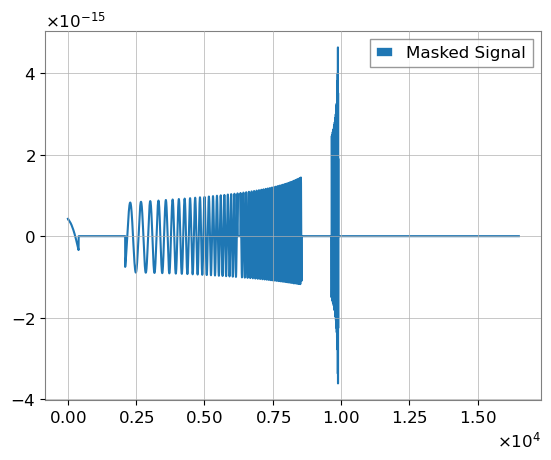

[ True  True  True ...  True  True  True]


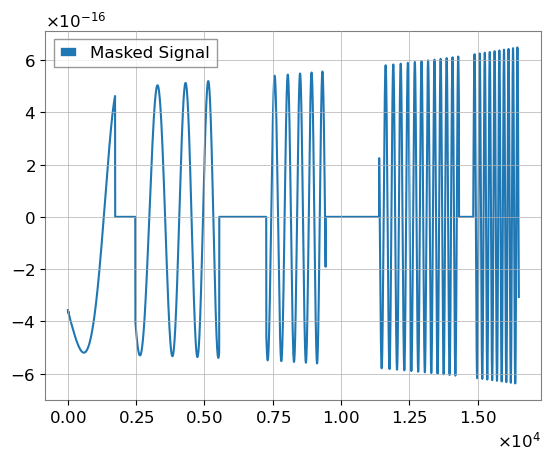

[ True  True  True ...  True  True  True]


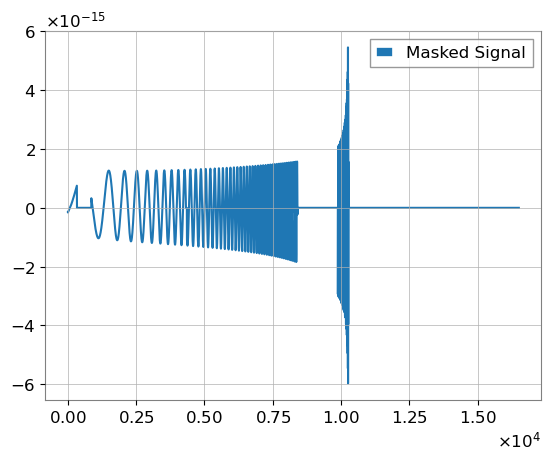

[ True  True  True ...  True  True  True]


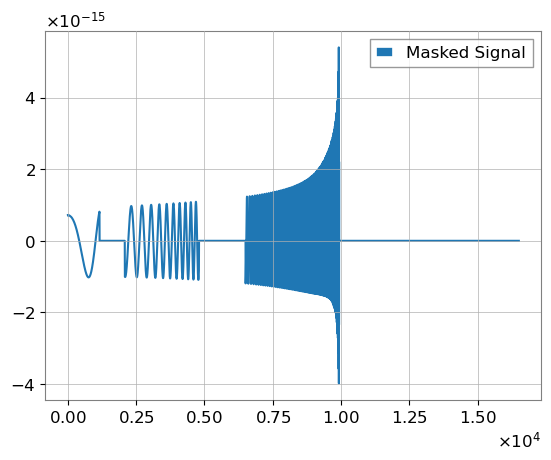

[ True  True  True ...  True  True  True]


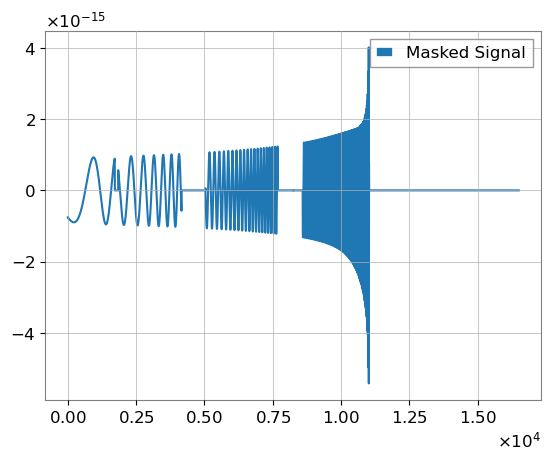

/home/ljq/code/RingdownGapFilling/utils/normalize.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/ljq/pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  signal=torch.tensor(signal)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
import torch
import os

from config.config import Config
from utils.mask import generate_continuous_masks_IMR
import torch
from torch.utils.data import DataLoader
from config.config import Config
from data.data_generation_IMR import generate_data
from dataset.dataset import GWSignalDataset
#from model.mymodel import MaskedConditionalAutoencoder
from model.mymodel_4 import IMRGapsFiller
from trainer.trainer import train_the_model
from utils.visualization import visualize_waveform_with_noise
from utils.normalize import normalize
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 测试阶段

    
if __name__ == "__main__":
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # def estimate_physical_parameters(signal):
    signal_length=Config.signal_length_IMR
    gap_size = signal_length//Config.signal_to_gap_length_ratio
    model = IMRGapsFiller().to(device)
    #model_path = '/home/ljq/code/Ringdown_gap_filling/Proj/saved_models/model.pth'
    model.load_state_dict(torch.load('/home/ljq/code/RingdownGapFilling/saved_models/IMR/model_IMR.pth'))

    # 切换到评估模式
    model.eval()

    test_num=500
    SAVE_PATH = 'data/signal_test_data_IMR.npz'  
    TEMP_DIR= 'data/temp_test'  # 临时文件目录

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #清空临时目录
    for f in os.listdir(TEMP_DIR):
        os.remove(os.path.join(TEMP_DIR, f))
    # 重新创建临时目录
    os.makedirs(TEMP_DIR, exist_ok=True)  # 创建临时文件目录
    # 生成测试集数据
    test_signals, test_conditions = generate_data(
            num_samples=test_num,TEMP_DIR=TEMP_DIR,SAVE_PATH=SAVE_PATH
        )
    #test_signals[0]=torch.zeros(signal_length)
    test_signals=test_signals[:,50:50+signal_length]
    print(test_signals.shape)
    #masks=generate_continuous_mask(test_num,signal_length,gap_size,start=int(1/2*Config.signal_length))
    num_gaps=10
    test_signals = torch.tensor(test_signals, dtype=torch.float32)
    masks = generate_continuous_masks_IMR(test_signals.size(0), signal_length, gap_size,num_gaps)
    #masks2=generate_continuous_mask(signals.size(0), signal_length, gap_size,start=int(1/2*Config.signal_length)+gap_size)
    masked_signals = []
    signals_copy=test_signals 
    test_signals,mean,std=normalize(test_signals)
    for i in range(signals_copy.size(0)):
        masked_signal = np.copy(signals_copy[i])
        masked_signal[~masks[i].numpy()] = 0  # 将掩码位置的信号置为0
        #绘制前几个masked信号
        if i< 5:
            print(masks[i].numpy())
            plt.plot(masked_signal, label='Masked Signal')
            plt.legend()
            plt.show()

        
        masked_signals.append(masked_signal)

    # masked_datas=masked_signals
    # #masked_datas_copy,_,_=normalize(masked_datas)
    # whitened_masked_datas=[]
    # for i in range(signals_copy.size(0)):
    #     masked_data=np.copy(masked_datas[i])
        
    #     whitened_masked_data,_,_=whiten(masked_data, sample_rate=2,psd=psd_interp_func,highpass=2e-3)
    #     whitened_masked_datas.append(whitened_masked_data)
    masked_signals,_,_=normalize(masked_signals)
    processed_signals = []
    processed_masked_datas = []

    i=0
    for signal, masked_signal in zip(test_signals, masked_signals):
        # 对原始信号进行小波变换和分段
        transformed_signal = wavelet_bandpass(signal)
        segmented_signal = segment_signal_IMR(transformed_signal)

        # 对掩码信号进行小波变换和分段
        transformed_masked_signal = wavelet_bandpass(masked_signal)
        segmented_masked_signal = segment_signal_IMR(transformed_masked_signal)

        processed_signals.append(segmented_signal)
        processed_masked_datas.append(segmented_masked_signal)
        print(i)
        i+=1
        
    print(1)
    processed_test_masked_signals_tensor = torch.tensor(processed_masked_datas, dtype=torch.float32).to(device)
    std=std.cpu().numpy()
    mean=mean.cpu().numpy()

    


In [7]:
print(std,mean)

[6.9887598e-16 6.9958685e-16 7.0033272e-16 ... 2.6885053e-16
 2.7257012e-16 2.9266259e-16] [ 1.3807835e-17  8.0662236e-18  6.2107773e-18 ... -1.7444877e-17
 -1.7204364e-17 -1.4759824e-17]


In [8]:

with torch.no_grad():
    reconstructed_signals_tensor = model(processed_test_masked_signals_tensor)

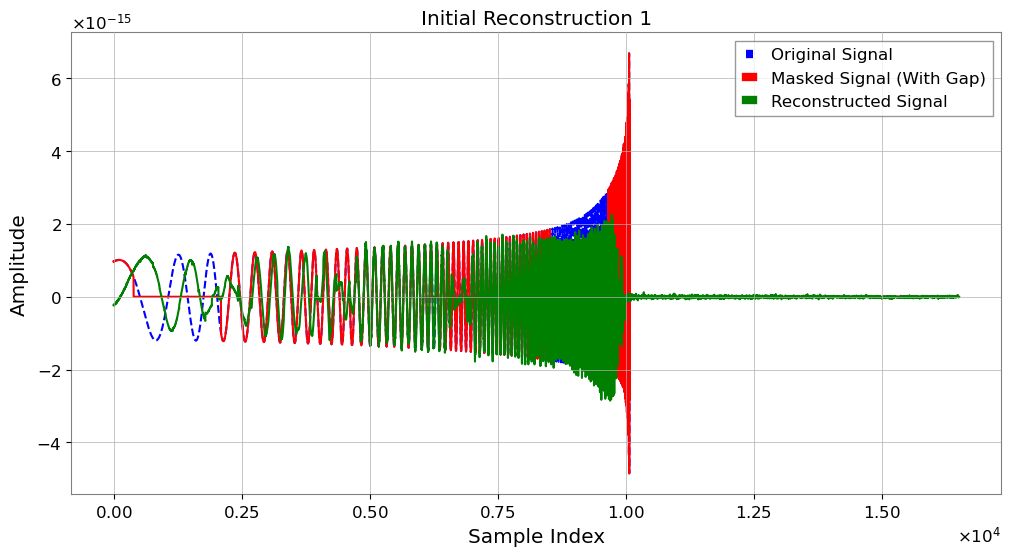

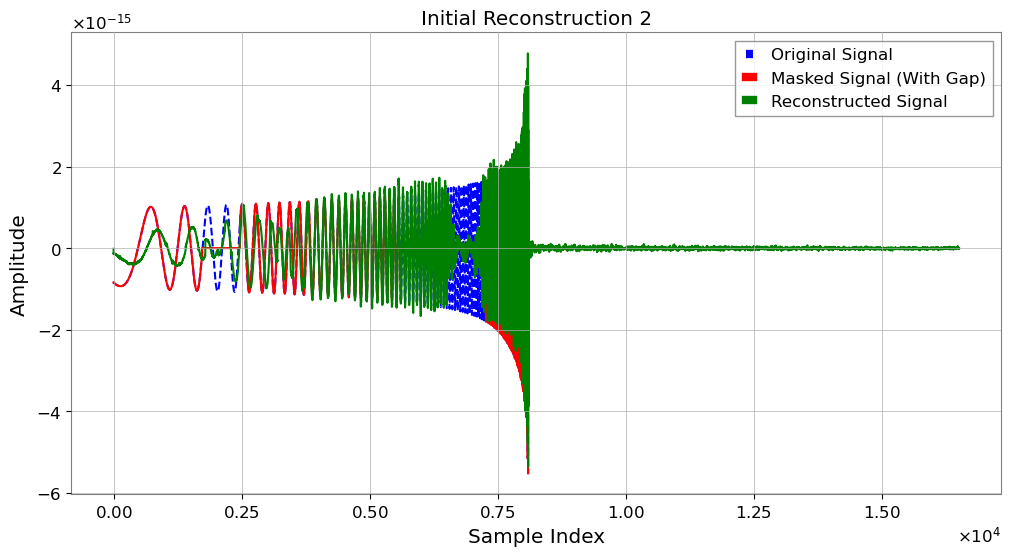

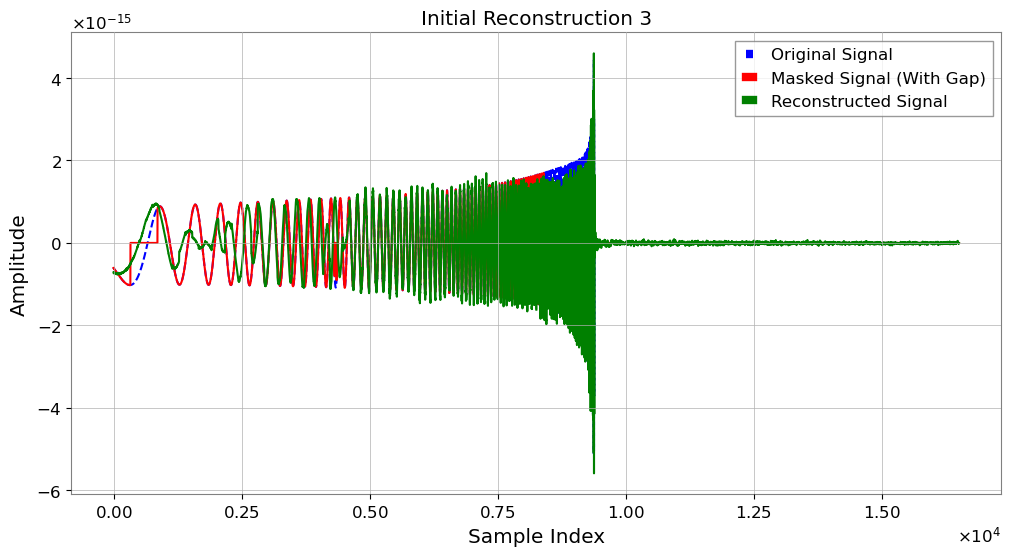

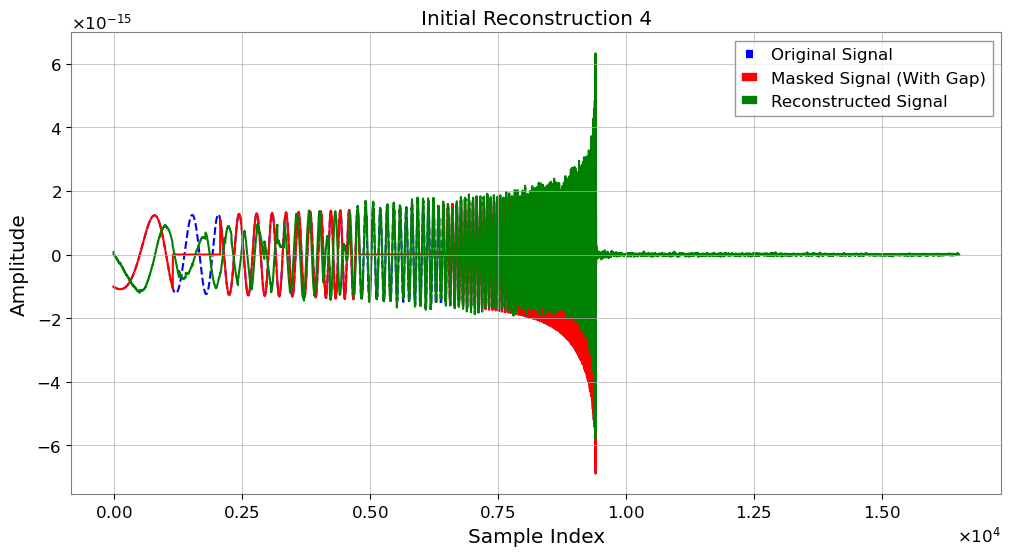

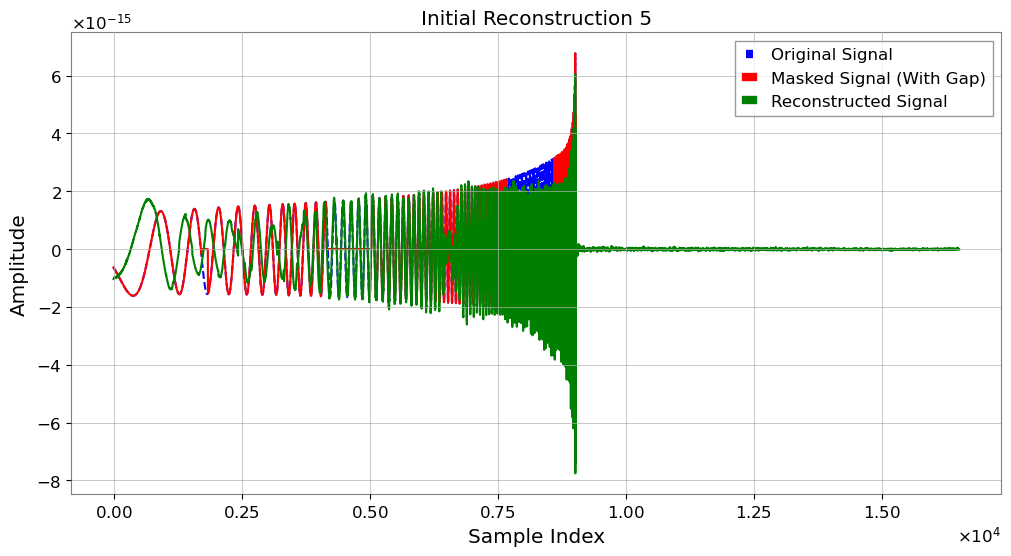

[-1.8415934e-16 -7.1778101e-17 -1.0556106e-16 ... -1.2294880e-17
 -1.0563331e-17 -9.4875027e-18]


In [10]:
from utils.visualization import visualize_waveform
#    initial_reconstructed_signals = mean_t+std_t*reconstructed_signals_tensor.cpu().squeeze(-1).numpy()
# for i in range(5):
#     print(f"Signal {i}:")
#     print("Original signal contains NaN:", torch.isnan(torch.tensor(n_test_signals[i])).any())
#     print("Masked signal contains NaN:", torch.isnan(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any())
#     print("Reconstructed signal contains NaN:", torch.isnan(torch.tensor(initial_reconstructed_signals[i])).any())

#     print("Original signal contains Inf:", torch.isinf(torch.tensor(n_test_signals[i])).any())
#     print("Masked signal contains Inf:", torch.isinf(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any())
#     print("Reconstructed signal contains Inf:", torch.isinf(torch.tensor(initial_reconstructed_signals[i])).any())

#     # 如果没有NaN或者Inf，才进行可视化
#     if not (torch.isnan(torch.tensor(n_test_signals[i])).any() or
#             torch.isnan(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any() or
#             torch.isnan(torch.tensor(initial_reconstructed_signals[i])).any() or
#             torch.isinf(torch.tensor(n_test_signals[i])).any() or
#             torch.isinf(torch.tensor(masked_test_signals_tensor.cpu().numpy()[i])).any() or
#             torch.isinf(torch.tensor(initial_reconstructed_signals[i])).any()):
#         visualize_waveform(
#             n_test_signals[i],
#             masked_test_signals_tensor.cpu().numpy()[i],
#             initial_reconstructed_signals[i],
#             title=f'Initial Reconstruction {i+1}'
#         )
#     else:
#         print(f"Signal {i} contains NaN or Inf, skipping visualization.")
# for i in range(5):
#     print(f"Signal {i}:")
#     print(f"Original signal min: {n_test_signals[i].min()}, max: {n_test_signals[i].max()}")
#     print(f"Masked signal min: {masked_test_signals_tensor.cpu().numpy()[i].min()}, max: {masked_test_signals_tensor.cpu().numpy()[i].max()}")
#     print(f"Reconstructed signal min: {initial_reconstructed_signals[i].min()}, max: {initial_reconstructed_signals[i].max()}")
#print(masks.size(),test_signals.size())
#test_masked_signals=masks.cpu().numpy()*test_signals.cpu().numpy()
#print(masked_test_signals)
# 可视化初步复原结果

# print(type(test_signals.cpu().numpy()))
# masked_datas,masked_signals=masked_datas.cpu().numpy(),masked_signals.cpu().numpy()

for i in range(5):
    pos_set=10
    masked_signal = np.copy(signals_copy[i+pos_set])
    masked_signal[~masks[i].numpy()] = 0  # 将掩码位置的信号置为0
    visualize_waveform(
        signals_copy[i+pos_set].cpu(),
        masked_signal,
        
        #noises[i].cpu(),
        reconstructed_signals_tensor.cpu().numpy()[i+pos_set][0]*std+mean,
        title=f'Initial Reconstruction {i+1}'
        )
print(reconstructed_signals_tensor.cpu().numpy()[0][0]*std+mean-signals_copy[0].numpy())
# 参数估计
estimated_conditions = []
for i in range(reconstructed_signals_tensor.size(0)):
    estimated_params = test_conditions[i]
    estimated_conditions.append(estimated_params)
#estimated_conditions_tensor = torch.tensor(estimated_conditions, dtype=torch.float32).to(device)
estimated_conditions_tensor = torch.tensor(np.array(estimated_conditions), dtype=torch.float32).to(device)

# # 第二次复原：使用估计的条件输入
# with torch.no_grad():
#     final_reconstructed_signals_tensor = model(
#         test_signals_tensor,
#         masks,
#         estimated_conditions_tensor,  # 使用估计的条件输入
#         gap_start
#         )
#     final_reconstructed_signals = final_reconstructed_signals_tensor.cpu().squeeze(-1).numpy()
#     final_reconstructed_signals= std_t*final_reconstructed_signals+mean_t
# # 可视化最终复原结果
# for i in range(5):
#     visualize_waveform(
#         test_signals[i],
#         masked_test_signals[i],
#         final_reconstructed_signals[i],
#         title=f'Final Reconstruction with Estimated Conditions {i+1}'
#         )

: 

: 

: 

: 

: 

: 

: 

: 